C:\ProgramData\anaconda3\envs\ai_pipeline_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


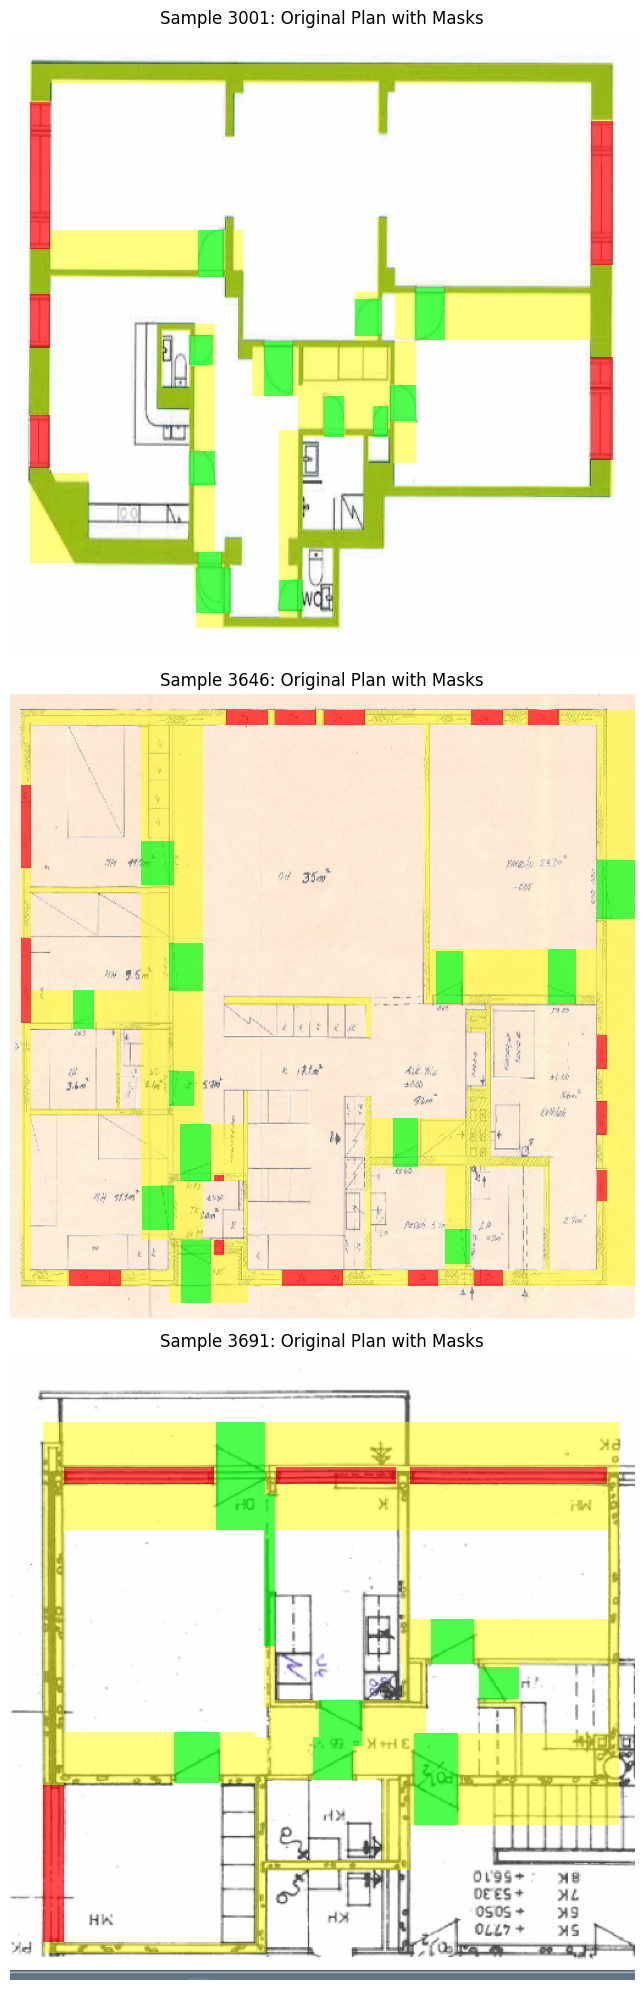

In [1]:
import os
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1)

# --- COLOR DEFINITIONS ---
# Background: Transparent (You see the original B&W image)
# Door (Class 0): Green
# Wall (Class 1): Yellow
# Window (Class 2): Red
colors_list = [
    (0, 0, 0, 0),     # 0: Background
    (0, 1, 0, 0.7),   # 1: Door (Green)
    (1, 1, 0, 0.5),   # 2: Wall (Yellow)
    (1, 0, 0, 0.7)    # 3: Window (Red)
]
custom_cmap = ListedColormap(colors_list)

class FloorPlanDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        all_files = os.listdir(data_dir)
        self.images = sorted([f for f in all_files if f.endswith('.png') and f.replace('.png', '.txt') in all_files])
        
    def __len__(self):
        return len(self.images)
    
    def yolo_to_mask(self, label_path, img_h, img_w):
        mask = np.zeros((img_h, img_w), dtype=np.int64)
        if not os.path.exists(label_path):
            return mask
            
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # DRAWING ORDER PRIORITY:
        # Walls (Class 1) drawn first
        # Windows (Class 2) drawn second (overwrites walls)
        # Doors (Class 0) drawn last (overwrites everything)
        draw_order = {1: 0, 2: 1, 0: 2}
        
        lines.sort(key=lambda x: draw_order.get(int(x.split()[0]), -1))

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5: continue
            
            cls_id = int(parts[0])
            cls_mask = cls_id + 1
            cx, cy, bw, bh = map(float, parts[1:])
            
            x1 = int((cx - bw / 2) * img_w)
            y1 = int((cy - bh / 2) * img_h)
            x2 = int((cx + bw / 2) * img_w)
            y2 = int((cy + bh / 2) * img_h)
            
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img_w, x2), min(img_h, y2)
            mask[y1:y2, x1:x2] = cls_mask
            
        return mask

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label_path = os.path.join(self.data_dir, img_name.replace('.png', '.txt'))
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        
        mask = self.yolo_to_mask(label_path, orig_h, orig_w)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            
        return image, mask

# --- PIPELINE ---
transform = A.Compose([
    A.Resize(512, 512), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

dataset = FloorPlanDataset('../data/black_and_white', transform=transform)
indices = random.sample(range(len(dataset)), 3)

fig, axes = plt.subplots(3, 1, figsize=(10, 20))
for i, idx in enumerate(indices):
    img, mask = dataset[idx]
    
    # De-normalization for display
    img_np = (img.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)
    
    axes[i].imshow(img_np)
    axes[i].imshow(mask.numpy(), cmap=custom_cmap, vmin=0, vmax=3, interpolation='nearest')
    axes[i].set_title(f"Sample {idx}: Original Plan with Masks")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [2]:
import os
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import jaccard_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = '../data/black_and_white'
NUM_CLASSES = 4 
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-4

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

colors_list = [(0,0,0,0), (0,1,0,0.7), (1,1,0,0.5), (1,0,0,0.7)]
CUSTOM_CMAP = ListedColormap(colors_list)

class FloorPlanDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        all_files = os.listdir(data_dir)
        self.images = sorted([f for f in all_files if f.endswith('.png') and f.replace('.png', '.txt') in all_files])
        
    def __len__(self):
        return len(self.images)
    
    def yolo_to_mask(self, label_path, img_h, img_w):
        mask = np.zeros((img_h, img_w), dtype=np.int64)
        if not os.path.exists(label_path): return mask
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        draw_order = {1: 0, 2: 1, 0: 2}
        lines.sort(key=lambda x: draw_order.get(int(x.split()[0]), -1))

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5: continue
            cls_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])
            x1 = int((cx - bw/2) * img_w)
            y1 = int((cy - bh/2) * img_h)
            x2 = int((cx + bw/2) * img_w)
            y2 = int((cy + bh / 2) * img_h)
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img_w, x2), min(img_h, y2)
            mask[y1:y2, x1:x2] = cls_id + 1
        return mask

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label_path = os.path.join(self.data_dir, img_name.replace('.png', '.txt'))
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        mask = self.yolo_to_mask(label_path, h, w)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        return image, mask

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

full_dataset = FloorPlanDataset(DATA_DIR, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0", 
    num_labels=NUM_CLASSES, 
    ignore_mismatched_sizes=True,
    use_safetensors=True
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    
    for imgs, masks in pbar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()
        optimizer.zero_grad()
        
        outputs = model(imgs).logits
        logits = torch.nn.functional.interpolate(outputs, size=(512, 512), mode="bilinear", align_corners=False)
        
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs).logits
            pred = torch.nn.functional.interpolate(out, size=(512, 512), mode="bilinear")
            pred = torch.argmax(pred, dim=1).cpu().numpy()
            val_preds.append(pred.flatten())
            val_targets.append(masks.numpy().flatten())
    
    y_true = np.concatenate(val_targets)
    y_pred = np.concatenate(val_preds)
    miou = jaccard_score(y_true, y_pred, average='macro')
    print(f"Validation mIoU: {miou:.4f}")

Loading weights: 100%|█| 192/192 [00:00<00:00, 803.35it/s, Materializing param=segformer.encoder.patch_embeddings.3.pro
SegformerForSemanticSegmentation LOAD REPORT from: nvidia/mit-b0
Key                                           | Status     | 
----------------------------------------------+------------+-
classifier.bias                               | UNEXPECTED | 
classifier.weight                             | UNEXPECTED | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | MISSING    | 
decode_head.batch_norm.num_batches_tracked    | MISSING    | 
decode_head.classifier.bias                   | MISSING    | 
decode_head.batch_norm.weight                 | MISSING    | 
decode_head.batch_norm.running_var            | MISSING    | 
decode_head.linear_fuse.weight                | MISSING    | 
decode_head.classifier.weight                 | MISSING    | 
decode_head.batch_norm.running_mean           | MISSING    | 
decode_he